In [1]:
from keras.datasets import boston_housing
# we're predicting targets, not training on classes
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

/Users/garethjones/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Things I can do to explore the dataset include: (1) look at shape of data, (2) look at length of each sample, (3) look at a single line

import numpy as np

print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)

# we can see that each feature of our data is scaled differently, so we have to normalise each on it's own
print("The top line of the data is: ",train_data[0])
print("The min value of each column is: ",np.min(train_data,axis=0))
print("The max value of each column is: ",np.max(train_data,axis=0))


(404, 13)
(404,)
(102, 13)
(102,)
The top line of the data is:  [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
The min value of each column is:  [6.3200e-03 0.0000e+00 4.6000e-01 0.0000e+00 3.8500e-01 3.5610e+00
 2.9000e+00 1.1296e+00 1.0000e+00 1.8800e+02 1.2600e+01 3.2000e-01
 1.7300e+00]
The max value of each column is:  [ 88.9762 100.      27.74     1.       0.871    8.725  100.      10.7103
  24.     711.      22.     396.9     37.97  ]


In [3]:
# one way to normalise the data is to "zero centre" it by subtracting the mean from each value
# zero-centring is a destructive process if we run it twice, so let's be sure to do it once only by re-importing the data here again

(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

# we centre everthing around zero
# we can't
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

print("min", np.min(train_data,axis=0))
print("max", np.max(train_data,axis=0))
print("mean", np.mean(train_data,axis=0))
print("std", np.std(train_data,axis=0))


min [-0.40510053 -0.48361547 -1.56469648 -0.25683275 -1.47126853 -3.81725032
 -2.36904226 -1.28750316 -0.97156928 -1.31131055 -2.67375227 -3.77110135
 -1.51966384]
max [9.23484718 3.72899018 2.44537425 3.89358447 2.67733525 3.46718635
 1.11048828 3.43740568 1.67588577 1.83609694 1.60353052 0.44807713
 3.48201936]
mean [-1.01541438e-16  1.09923072e-17  1.80933376e-15 -7.80453809e-17
 -5.25047552e-15  6.43187374e-15  2.98441140e-16  4.94653823e-16
  1.12671149e-17 -1.05526149e-16  2.36614908e-14  5.96710525e-15
  6.13920356e-16]
std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
from keras import models, layers

# we can set the input shape to the width of the shape of our dataset which is quite nice
# in this case, we're putting 13 features into 64 nodes, so we're going to be creating a load of artificial features in the data
# for loss, we can use mean squared error, but for metrics it's easier for humans to understand mean absolute error
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation="relu",input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
# now we want to create a validation dataset. let's to a K-fold cross validation

k=4
num_val_samples = len(train_data)//k # double slash makes sure this is an integer
num_epochs = 500

# this is what I want to be able to collect to monitor my training
all_scores = []
all_histories = []
all_models = []

for i in range(k):
    print("Fold:",str(i+1))
    
    # we're running through our dataset and selecting portions of it to be a validation set
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    # the partial data is the remainder of our train data that we will use to optimise the model
    # again we're doing some maths to run through the dataset and find each chunk
    train_data_left = train_data[0:i*num_val_samples]
    train_data_right = train_data[(i+1)*num_val_samples:]
    partial_train_data = np.concatenate([train_data_left,train_data_right],axis=0)
    
    train_targets_left = train_targets[0:i*num_val_samples]
    train_targets_right = train_targets[(i+1)*num_val_samples:]
    partial_train_targets = np.concatenate([train_targets_left,train_targets_right],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
             epochs=num_epochs,
             batch_size=1,
             verbose=0,validation_data=(val_data,val_targets)
                    ) # this is you how much information you see during training, which we can turn off
    
    # we can then also save the model after each step
    model.save(str(i+1)+"-model.h5")
    
    # the first thing evaluate returns is the loss of the model, and then it also returns the mae    
    # val_mse,val_mae = model.evaluate(val_data,val_targets)
    
    all_scores.append(val_mae)
    all_histories.append(history)
    all_models.append(model)

Fold: 1
Fold: 2
Fold: 3
Fold: 4


The validation MAE of each fold is:  [2.3571325245470103, 2.3571325245470103, 2.3571325245470103, 2.3571325245470103]


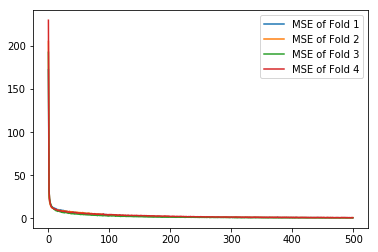

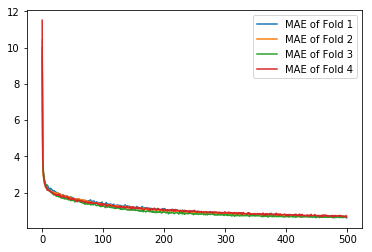

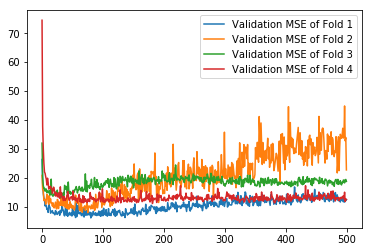

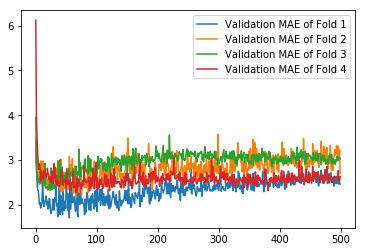

In [24]:
import matplotlib.pyplot as plt

print("The validation MAE of each fold is: ",all_scores)

# now let's plot the loss (MSE) of each fold, and MAE because it's easier for us to understand

for i in range(k):
    plt.plot(all_histories[i].history['loss'],label='MSE of Fold ' + str(i+1))
plt.legend()
plt.show()
plt.close()

for i in range(k):
    plt.plot(all_histories[i].history['mean_absolute_error'],label='MAE of Fold ' + str(i+1))
    plt.legend()
plt.show()
plt.close()

# and do the same for the validation data stored in history

for i in range(k):
    plt.plot(all_histories[i].history['val_loss'],label='Validation MSE of Fold ' + str(i+1))
    plt.legend()
plt.show()
plt.close()

for i in range(k):
    plt.plot(all_histories[i].history['val_mean_absolute_error'],label='Validation MAE of Fold ' + str(i+1))
    plt.legend()
plt.show()
plt.close()